# End-to-End Deep Learning with Pachyderm, Determined, and Seldon Core

This notebook walks through an example "Deep Learning Platform", using all open source tools.  In particular, we're going to use:

- [Pachyderm](https://www.pachyderm.com/) to manage, version, and transform our data
- [Determined](https://www.determined.ai) to train a model and manage model artifacts
- [Seldon Core](http://seldon.io/) to serve our model as a REST service

Setup artifacts can be found in REPOSITORY

## Creating a Pachyderm Repository for our Training Data

Pachyderm lets us create and use 'repositories' of data (think Git for data). In this example we're going to use the [Asirra Cats and Dogs Kaggle Dataset](https://www.kaggle.com/c/dogs-vs-cats/overview), which we assume we've downloaded locally.

In [1]:
import random
import os
import matplotlib.pyplot as plt
from skimage import io

asirra_image_path = "./data/dogs-vs-cats/train"


train_files = []
for root, dirs, files in os.walk(asirra_image_path):
    for name in files:
        if name.endswith('.jpg'):
            train_files.append(os.path.join(root,name))      
print(f"There are {len(train_files)} train images")

There are 25000 train images


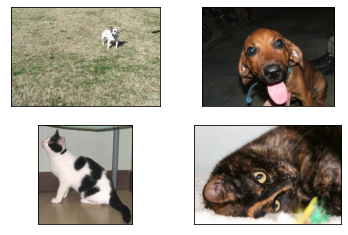

In [2]:
# Visualize some sample images to see what we're working with

NUM_SAMPLES = 4
samples = [io.imread(f) for f in random.sample(train_files, 4)]
f, axarr = plt.subplots(2,2)
for i in range(NUM_SAMPLES):
    j = int(i / 2)
    k = i % 2
    axarr[j,k].imshow(samples[i])
    axarr[j,k].set_xticks([])
    axarr[j,k].set_yticks([])
plt.show()

To set up Pachyderm, [follow their deployment docs](https://docs.pachyderm.com/latest/deploy-manage/).  I used the [deploy on Amazon EKS](https://docs.pachyderm.com/latest/deploy-manage/deploy/amazon_web_services/deploy-eks/) instructions to set up a Kubernetes cluster and deploy Pachyderm.  We're going to start by creating a Pachyderm repository for our source images:

![Making a Pachyderm Repository](resources/upload_to_pachyderm.png)

You'll need to expose your pachyderm service so that it can communicate with Determined -- this is doable by making the `pachd` Kubernetes service a `LoadBalancer`.  For security reasons, you'll also want to configure AWS security groups to control the IP addresses that communicate with Pachyderm (make sure to include Determined!)

Take note of the IP address of the `pachd` service, and enter it below as `pachyderm_host`

In [3]:
import python_pachyderm

pachyderm_host = "PACHD_HOST"
pachyderm_port = 650
client = python_pachyderm.Client(host=pachyderm_host, port=pachyderm_port)

Next we'll make a repository named `train`, and we'll commit all of the files to the `master` branch of that repository.

In [ ]:
client.create_repo('train')
commit = client.commit('train', 'master')
python_pachyderm.put_files(client, "data/dogs-vs-cats/train", commit, '/')


## Preparing our Data with Pachyderm Pipelines

Pachyderm also allows us to build [pipelines](https://docs.pachyderm.com/latest/concepts/pipeline-concepts/) that transform our data and create downstream repositories of transformed data.  They can be configured to do really cool things -- here we're just going to do a very simple train / validation split and compress the files for easier download.

![](resources/pachyderm_pipeline.png)

In [ ]:
# Compress Training Data
python_pachyderm.create_python_pipeline(
        client,
        "./pachyderm/train_compress/main.py",
        python_pachyderm.Input(pfs=python_pachyderm.PFSInput(glob="/*", repo="train")),
        pipeline_name="split_and_compress",
    )

## Training a Deep Learning model with Determined
I [installed Determined in AWS here](https://docs.determined.ai/latest/how-to/installation/aws.html?highlight=aws) to match the EKS cluster.  This will make it easier to share resources via IAM roles in AWS.

The integration with Pachyderm takes the form of a [simple python connector to download a Pachyderm repository](det/data.py), which we can use to load data into our ML model.


### Distributed Hyperparameter Tuning with Determined
We define a [ResNet50 model in PyTorch](det/model_def.py) to perform this classification problem. If we were just training locally, we'd be stuck slowly trying out hyperparameter configurations, manually tracking the results, trying to figure out how to track checkpoints -- it would be a painful process.

With Determined, we'll launch [an adaptive hyperparameter search](https://docs.determined.ai/latest/topic-guides/hp-tuning-det/index.html?highlight=adaptive), a state-of-the-art hyperparameter search algorithm that will produce a high-performing model.  Determined will handle tracking all of the relevant metadata (logs, checkpoints, code version, etc.)


![](resources/train.png)


In [5]:
!det e create det/adaptive.yaml det/

Preparing files (/Users/davidhershey/Repos/GitHub/e2e-example/det) to send to master... 18.8KB and 10 files
Created experiment 11


### Testing the trained model locally

Determined manages our model artifacts, so after training is completed we can easily retreive the best performing checkpoint of our model, and instanciate it with the [Determined checkpoint export API](https://docs.determined.ai/latest/reference/api/experimental.html?highlight=checkpoint#determined.experimental.Checkpoint).  Let's do that, and test the model on an image of my dog.

In [6]:
from determined.experimental import Determined
import torch

EXPERIMENT_ID = 1

checkpoint = Determined().get_experiment(EXPERIMENT_ID).top_checkpoint()
checkpoint_path = checkpoint.download()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = checkpoint.load(map_location=device)

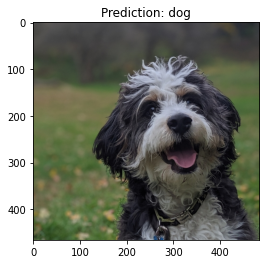

In [7]:
from utils import predict

predict(model, 'dog.png')

## Deploying our Model with Seldon

Seldon Core is an open source tool that makes it easy to deploy ML inference graphs into Kubernetes.  I installed seldon into the same EKS cluster as we made before using Helm (with Ambassador Ingress), [following the instructions here](https://docs.seldon.io/projects/seldon-core/en/latest/workflow/install.html).  

Our task is pretty simple, we just want to host our model as a REST endpoint:

![](resources/serve.png)

Steps needed:
- Wrapped our model using the [Seldon Core Python language wrapper](https://docs.seldon.io/projects/seldon-core/en/latest/python/index.html) in [CatDogModel.py](seldon/CatDogModel.py)
- Wrapper our model in a Docker image, [per the seldon documentation](https://docs.seldon.io/projects/seldon-core/en/latest/python/python_wrapping_docker.html)
- Built a deployment manifest, [serve.yaml](seldon/serve.yaml) that specifies what we want to deploy

Now we'll just use `kubectl` to deploy the model.

In [ ]:
!kubectl apply -f serve.yaml

Seldon creates an endpoint with Ambassador, which we take note of below.  Then we'll send that same picture of my dog to the endpoint and verify that we get the same result.

/Users/davidhershey/.virtualenvs/det/lib/python3.7/site-packages/urllib3/connectionpool.py:986: InsecureRequestWarning: Unverified HTTPS request is being made to host 'a7eb9bc07955c11ea846a0e381adf7a8-1567038751.us-west-2.elb.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


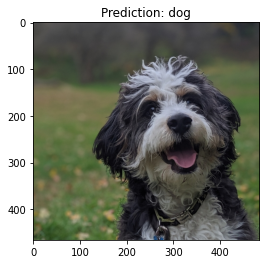

In [9]:
import requests 
import json
import matplotlib.pyplot as plt

AMBASSADOR_HOST = ""

endpoint = f"{AMBASSADOR_HOST}/seldon/default/catdog-model/api/v1.0/predictions"
image = io.imread(image)
data = {'data': {'ndarray': image.tolist()}}  
headers = {'content-type': 'application/json'}
  
prediction = requests.post(url=endpoint, data=json.dumps(data), headers=headers, verify = False).json()['data']['ndarray'][0]
plt.imshow(image)
plt.title(f"Prediction: {prediction}")
plt.show()

There we go!  With just a bit of polish, you can turn this concept into a full-blown platform that allows for end-to-end ML on just about any infrastructure.